In [2]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np

C:\Users\nito8\AppData\Local\Temp\ipykernel_588\3475736524.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download([ticker, cash_ticker], period="max")['Close'].ffill()
[*********************100%***********************]  2 of 2 completed


Strategy
 0.0    2960
-1.0    2032
 1.0    1273
Name: count, dtype: int64


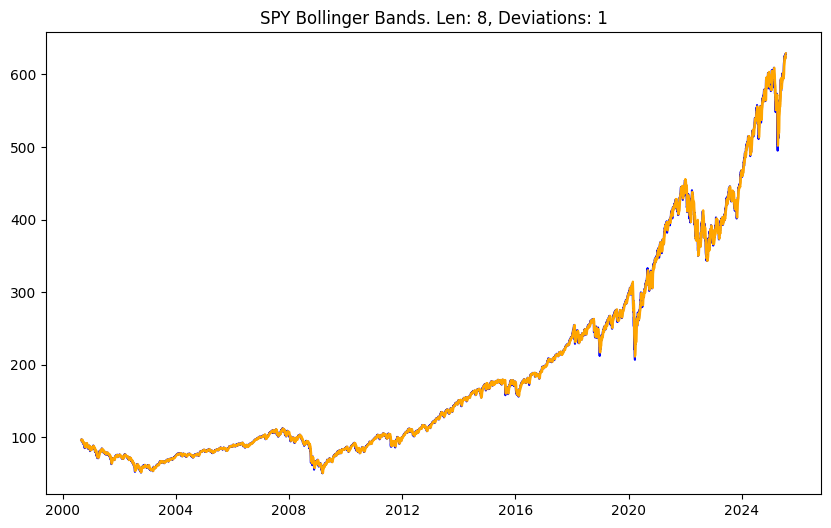

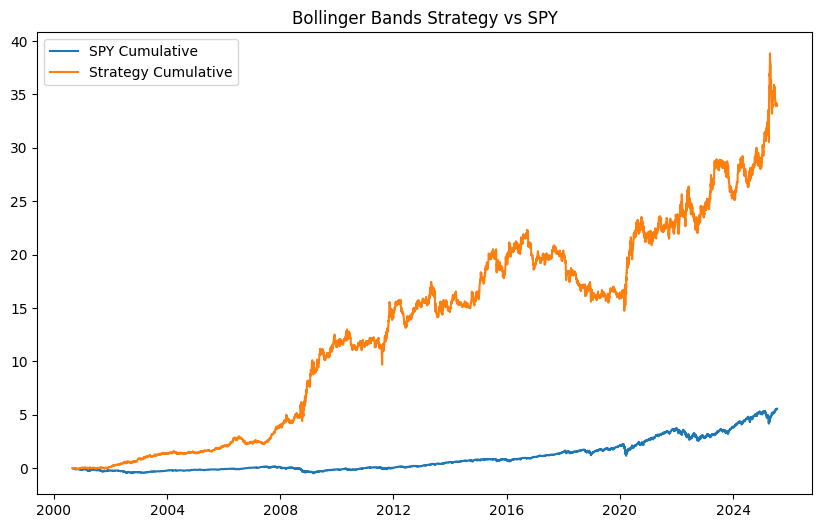

In [ ]:
BB_LEN = 8
STD = 1
LOOKBACK = 10000
TICKER = 'SPY'
CASH_TICKER = 'GC=F'

def get_data(ticker = TICKER, cash_ticker=CASH_TICKER, lookback = LOOKBACK):
    df = yf.download([ticker, cash_ticker], period="max")['Close'].ffill()
    df.columns = df.columns.get_level_values(0)
    return df.iloc[-lookback:, :]

def add_bollinger_bands(df, ticker=TICKER, std=STD, bb_len=BB_LEN):
    df['BB_SMA'] = df[ticker].rolling(bb_len).mean()
    df['BB_STD'] = df[ticker].rolling(bb_len).std()

    df['Upper_Band'] = df['BB_SMA'] + (std * df['BB_STD'])
    df['Lower_Band'] = df['BB_SMA'] - (std * df['BB_STD'])

    df = df.dropna()

    plt.figure(figsize=(10, 6))
    plt.plot(df[ticker], color='blue')
    plt.plot(df['Upper_Band'], color='orange')
    plt.plot(df['Lower_Band'], color='orange')

    plt.title(f'{TICKER} Bollinger Bands. Len: {BB_LEN}, Deviations: {STD}')

    return df

def add_strategy(df, ticker=TICKER):
    df['Strategy'] = np.where(
        df[ticker] > df['Upper_Band'], -1, 
        np.where(df[ticker] < df['Lower_Band'], 1, 0)
    )
    df['Strategy'] = df['Strategy'].shift(1).fillna(0)
    
    return df

def test_strategy(df, ticker=TICKER, cash_ticker=CASH_TICKER):
    asset_ret = df[ticker].pct_change().fillna(0)
    cash_ret  = df[cash_ticker].pct_change().fillna(0)

    strat_daily = np.where(
        df['Strategy'] == 0,
        cash_ret,
        df['Strategy'] * asset_ret
    )

    df['Asset_Returns']    = (1 + asset_ret).cumprod() - 1
    df['Strategy_Returns'] = (1 + strat_daily).cumprod() - 1

    plt.figure(figsize=(10, 6))
    plt.plot(df['Asset_Returns'], label=f'{TICKER} Cumulative')
    plt.plot(df['Strategy_Returns'], label='Strategy Cumulative')
    plt.legend()
    plt.title(F'Bollinger Bands Strategy vs {TICKER}')

    return df


def main():
    df = get_data()
    df = add_bollinger_bands(df)
    df = add_strategy(df)
    df = test_strategy(df)

    return df

df = main()